# Visualizing MIOFlow trajectories

Prerequisites:
- You have trained your MIOFlow model decoded the trajectoreis back to gene space [notebook: 8-dimchanger-decode-back]: 
    

In this notebook, we will:
- Visualize different cell trajectories

# TODO: BETTER DESCRIPTION OF THIS NOTEBOOK

In [5]:
import scanpy as sc
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
PROCESSED_DATA_DIR = os.path.join('../../data', 'processed')
DIMENSION_CHANGER_DIR = os.path.join('../../dimension_changer')
RESULTS_DIR = os.path.join('../../results')

data_name = 'adata'
SAVE_PATH = os.path.join(RESULTS_DIR, data_name)

adata = sc.read(os.path.join(PROCESSED_DATA_DIR, 'adata_mioflow.h5ad'))
gene_names = adata.var_names

traj = np.load(os.path.join(SAVE_PATH,'traj_gene_sp.npy'))


In [6]:
adata.shape

(17944, 18019)

In [7]:
traj.shape

(100, 100, 18019)

In [8]:
traj_mean = traj.mean(axis=1)
traj_std = traj.std(axis=1)
traj_mean_std = traj_mean.std(axis=0)
zero_std_genes = traj_mean_std == 0
gene_names = np.array(gene_names)[~zero_std_genes]
traj, traj_mean, traj_std, traj_mean_std = traj[..., ~zero_std_genes], traj_mean[..., ~zero_std_genes], traj_std[..., ~zero_std_genes], traj_mean_std[..., ~zero_std_genes]
# traj_mean_normalized = (traj_mean - traj_mean.mean(axis=0)) / traj_mean.std(axis=0)
zero_mean_std_genes = (traj_mean.max(axis=0) - traj_mean.min(axis=0)) == 0
gene_names = gene_names[~zero_mean_std_genes]
traj_mean = traj_mean[:,~zero_mean_std_genes]
traj_mean_normalized = (traj_mean - traj_mean.min(axis=0)) / (traj_mean.max(axis=0) - traj_mean.min(axis=0))

trends_df = pd.DataFrame(traj_mean_normalized, columns=gene_names, index=[f't{i}' for i in range(traj_mean_normalized.shape[0])]).T
# Get the indices of top k values for each row
topk = 5
top_k_indices = trends_df.apply(lambda x: np.where(x >= sorted(x)[-topk])[0].mean(), axis=1)
# Sort the dataframe by mean of top k indices
trends_df_sorted = trends_df.iloc[top_k_indices.argsort()]

trends_df_sorted_numerical_index = trends_df_sorted.reset_index(drop=True)

# # Split indices into 5 groups using the cluster points
# cluster_pts = [816, 1740, 3120, 4032]
# cluster_groups = [
#     trends_df_sorted.index[:cluster_pts[0]].tolist(),
#     trends_df_sorted.index[cluster_pts[0]:cluster_pts[1]].tolist(),
#     trends_df_sorted.index[cluster_pts[1]:cluster_pts[2]].tolist(), 
#     trends_df_sorted.index[cluster_pts[2]:cluster_pts[3]].tolist(),
#     trends_df_sorted.index[cluster_pts[3]:].tolist()
# ]

# cluster_df = pd.DataFrame(np.arange(len(trends_df_sorted.index)), index=trends_df_sorted.index, columns=['number'])
# cluster_df['cluster'] = np.nan
# for i, cluster_group in enumerate(cluster_groups):
#     cluster_df.loc[cluster_group, 'cluster'] = i

#### Here we need to define a set of candidate important genes to look at.
We will use scprep function of highly variable genes for this purpouse

In [9]:
n_top_genes = 50
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
candidate_genes = adata.var_names[adata.var['highly_variable']]

(note: those “zero” ones are due to the fact that sc.pp.pca does an hvg beforehand, so only the top 2000 HVGs are used for PCA, and the ones that aren’t will be zero when reconstructing with PCA)


In [ ]:
# from stfe.gene_utils import get_markers_from_var_names

# # candidate_genes = ["Cldn4", "Gdf15", "Galactin3", "Sfn",
# # "Sftpb","Sftpc","Lamp3","Acoxl","Il33",
# # "Rtkn2","Cav1","Vegfa","Sema3a","Sema3e",
# # "Cdkn1a","Gdf15","Cldn4","Sprr1a","Lgals3",
# # "Ccng1","Edn1","Clu","Atf3","Fosl1"]
# to_plot_gene = get_markers_from_var_names(candidate_genes, adata.var_names, True, True)
# print(len(to_plot_gene),len(candidate_genes))
# print(len(to_plot_gene))
# to_plot_gene = np.unique(to_plot_gene)

60 60
60


In [19]:
to_plot_genes = candidate_genes
to_plot_genes = np.unique(to_plot_genes)

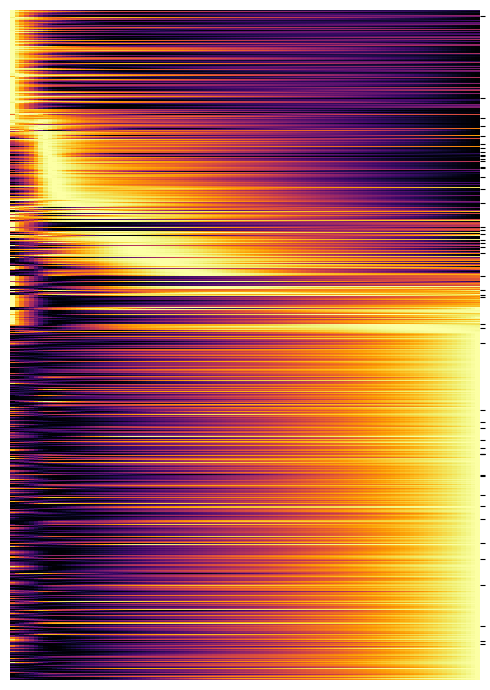

In [15]:
# Select genes to display on the y-axis
ytick_genes = to_plot_genes
ytick_positions = [trends_df_sorted.index.get_loc(gene) for gene in ytick_genes if gene in trends_df_sorted.index]
ytick_labels = [ytick_genes[i] for i, pos in enumerate(ytick_positions)]

# Create and save the heatmap separately
fig_heatmap = plt.figure(figsize=(5, 7))
ax_heatmap_only = plt.subplot(111)
sns.heatmap(trends_df_sorted, cmap='inferno', vmin=0, vmax=1,
            cbar=False, ax=ax_heatmap_only, yticklabels=False)
# Set the same y-ticks as the combined figure
ax_heatmap_only.yaxis.set_label_position("right")
ax_heatmap_only.yaxis.tick_right()
# Remove x-axis ticks and labels
ax_heatmap_only.set_xticks([])
ax_heatmap_only.set_xticklabels([])

ax_heatmap_only.set_yticks(ytick_positions)
# ax_heatmap_only.set_yticklabels(ytick_labels, fontsize=10)
# Set the same x-ticks as the combined figure
# ax_heatmap_only.set_xticks(tick_positions)
# ax_heatmap_only.set_xticklabels([f'Day {d}' for d in days], fontsize=10)
plt.tight_layout()
# plt.savefig(f'{output_dir}/gene_heatmap_cluster_heatmap.pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)